# Python применение статистических критериев на практике - пайплайн оценки A/B

## Домашнее задание:

###На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
###Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_excel('/content/drive/MyDrive/AB_Test_Results.xlsx')

In [4]:
data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [5]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [7]:
data.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

In [8]:
# Найдем все дублирующиеся USER_ID
duplicated_user_ids = data[data.duplicated(subset='USER_ID', keep=False)]['USER_ID'].unique()

# Создадим новый DataFrame, который будет содержать только строки с дублированными USER_ID
duplicated_data = data[data['USER_ID'].isin(duplicated_user_ids)]

# Удалим все строки с дублированными USER_ID
data_no_duplicates = data[~data['USER_ID'].isin(duplicated_user_ids)]

# Добавим обратно строки с дублированными USER_ID, оставляя только строки из контрольной группы
control_only_duplicates = duplicated_data[duplicated_data['VARIANT_NAME'] == 'control']
new_data = pd.concat([data_no_duplicates, control_only_duplicates], ignore_index=True)


In [9]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6814 entries, 0 to 6813
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       6814 non-null   int64  
 1   VARIANT_NAME  6814 non-null   object 
 2   REVENUE       6814 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 159.8+ KB


In [10]:
new_data.describe()

,USER_ID,REVENUE
count,6814.000000,6814.000000
mean,4983.343411,0.112241
std,2907.921095,2.612580
min,2.000000,0.000000
25%,2443.250000,0.000000
50%,4966.500000,0.000000
75%,7546.500000,0.000000
max,10000.000000,196.010000


In [11]:
print(new_data['VARIANT_NAME'].value_counts())

VARIANT_NAME
control    4984
variant    1830
Name: count, dtype: int64


In [14]:
control = new_data[new_data['VARIANT_NAME'] == 'control']
test = new_data[new_data['VARIANT_NAME'] == 'variant']

<class 'pandas.core.frame.DataFrame'>
Index: 1830 entries, 0 to 3661
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       1830 non-null   int64  
 1   VARIANT_NAME  1830 non-null   object 
 2   REVENUE       1830 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 57.2+ KB


(array([1.804e+03, 3.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.    ,  0.4608,  0.9216,  1.3824,  1.8432,  2.304 ,  2.7648,
         3.2256,  3.6864,  4.1472,  4.608 ,  5.0688,  5.5296,  5.9904,
         6.4512,  6.912 ,  7.3728,  7.8336,  8.2944,  8.7552,  9.216 ,
         9.6768, 10.1376, 10.5984, 11.0592, 11.52  , 11.9808, 12.4416,
        12.9024, 13.3632, 13.824 , 14.2848, 14.7456, 15.2064, 15.6672,
        16.128 , 16.5

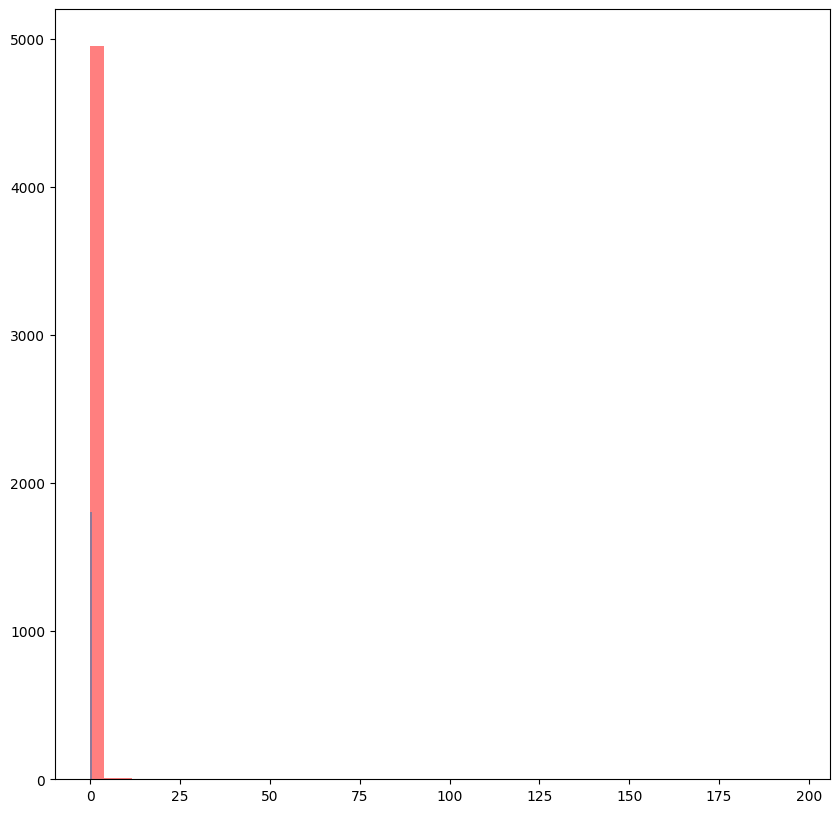

In [15]:
plt.figure(figsize=(10, 10))
control_revenue = control['REVENUE']
test_revenue = test['REVENUE']

plt.hist(control_revenue, color='r', bins=50, alpha = 0.5)
plt.hist(test_revenue, bins=50, alpha = 0.5)

In [16]:
# Вычислим средний доход и стандартное отклонение для каждой группы
mean_control = control['REVENUE'].mean()
mean_test = test['REVENUE'].mean()

std_control = control['REVENUE'].std()
std_test = test['REVENUE'].std()

n_control = control.shape[0]
n_test = test.shape[0]

print(f"Средний доход (control): {mean_control:.2f}")
print(f"Средний доход (test): {mean_test:.2f}")
print(f"Стандартное отклонение (control): {std_control:.2f}")
print(f"Стандартное отклонение (test): {std_test:.2f}")
print(f"Количество наблюдений (control): {n_control}")
print(f"Количество наблюдений (test): {n_test}")

Средний доход (control): 0.13
Средний доход (test): 0.07
Стандартное отклонение (control): 3.01
Стандартное отклонение (test): 0.88
Количество наблюдений (control): 4984
Количество наблюдений (test): 1830


In [17]:
# Проведем t-тест для независимых выборок
t_stat, p_value = stats.ttest_ind(test['REVENUE'], control['REVENUE'])

print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

t-статистика: -0.8745
p-value: 0.3819


In [18]:
# Выводы и рекомендации
if p_value < 0.05:
    print("Результаты статистически значимы. Тестовая группа показывает значимое изменение дохода.")
    if mean_test > mean_control:
        print("Рекомендация: Оставить изменения, так как тестовая группа показала увеличение дохода.")
    else:
        print("Рекомендация: Откатить изменения, так как тестовая группа показала уменьшение дохода.")
else:
    print("Результаты не статистически значимы. Изменение дохода не является значимым.")
    print("Рекомендация: Не вносить изменения на основе текущих данных.")

Результаты не статистически значимы. Изменение дохода не является значимым.
Рекомендация: Не вносить изменения на основе текущих данных.


## Рекомендуется провести повторный тест, так как присутствовали одни и те же пользователи в двух группах.